# **Harry Potter - Librerias Para el Modelo**

En este notebook se entrenará un modelo de aprendizaje basado en el conjunto de datos "Harry Potter Sorting Dataset" en Kaggle. El proceso consistirá en un EDA, seguido por el preprocesamiento de datos, el entrenamiento del modelo con tres modelos de clasificación, la búsqueda de los mejores hiperparámetros mediante GridSearchCV, su evaluación con métricas, y finalmente, la utilización del mejor modelo para serializarlo y exportarlo, con el fin de ser utilizado en una aplicación externa a este entorno.

El conjunto de datos puede encontrarse en el siguiente enlace:
https://www.kaggle.com/datasets/sahityapalacharla/harry-potter-sorting-dataset/data

Primero comenzamos con la importación completa de los paquetes y librerías necesarios.

In [1]:
from pathlib import Path

import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import joblib
from google.colab import files

El conjunto de datos de casas de Harry Potter contiene variables con los atributos de 1000 personajes ficticios de la saga, los cuales serán utilizados para predecir a qué casa pertenece cada uno, basándose en dichos atributos.

# **EDA**

Para el empezar con el EDA, primero descargamos el conjunto de datos utilizando kagglehub, el cual es la herramiento oficial de Kaggle para importarlos.

De igual manera, reemplazamos los espacios en los nombres de las variables por guiones bajos para evitar complicaciones.

In [2]:
path = kagglehub.dataset_download("sahityapalacharla/harry-potter-sorting-dataset")
filepath = Path(path) / "harry_potter_1000_students.csv"

df = pd.read_csv(filepath)

df.columns = [c.replace(' ', '_') for c in df.columns]

df

100%|██████████| 7.50k/7.50k [00:00<00:00, 4.68MB/s]

Extracting files...


,Blood_Status,Bravery,Intelligence,Loyalty,Ambition,Dark_Arts_Knowledge,Quidditch_Skills,Dueling_Skills,Creativity,House
0,Half-blood,9,4,7,5,0,8,8,7,Gryffindor
1,Muggle-born,6,8,5,7,5,6,4,9,Ravenclaw
2,Pure-blood,1,4,7,7,1,4,4,6,Hufflepuff
3,Pure-blood,9,1,3,4,1,9,10,1,Gryffindor
4,Muggle-born,5,9,7,3,3,6,7,9,Ravenclaw
...,...,...,...,...,...,...,...,...,...,...
995,Half-blood,7,10,3,7,1,1,3,8,Ravenclaw
996,Pure-blood,7,3,2,7,8,6,7,7,Slytherin
997,Half-blood,5,10,5,3,3,5,7,10,Ravenclaw
998,Half-blood,5,6,10,4,4,6,2,4,Hufflepuff


Como podemos visualizar, dataset ha sido importado correctamente.

Ahora visualizaremos los tipos de datos de las variables.

In [3]:
print('Dimensiones:', df.shape)
print('\nTipos de datos:')
print(df.dtypes)
print('\nPrimeras filas:')
df.head()

Dimensiones: (1000, 10)

Tipos de datos:
Blood_Status           object
Bravery                 int64
Intelligence            int64
Loyalty                 int64
Ambition                int64
Dark_Arts_Knowledge     int64
Quidditch_Skills        int64
Dueling_Skills          int64
Creativity              int64
House                  object
dtype: object

Primeras filas:


,Blood_Status,Bravery,Intelligence,Loyalty,Ambition,Dark_Arts_Knowledge,Quidditch_Skills,Dueling_Skills,Creativity,House
0,Half-blood,9,4,7,5,0,8,8,7,Gryffindor
1,Muggle-born,6,8,5,7,5,6,4,9,Ravenclaw
2,Pure-blood,1,4,7,7,1,4,4,6,Hufflepuff
3,Pure-blood,9,1,3,4,1,9,10,1,Gryffindor
4,Muggle-born,5,9,7,3,3,6,7,9,Ravenclaw


Como podemos observar, contamos con 8 variables numéricas (Bravery, Intelligence, Loyalty, Ambition, Dark_Arts_Knowledge, Quidditch_Skills, Dueling_Skills, Creativity), y 1 categórica (Blood_Status), sin contar nuestra variable objetivo, House, la cual representa la casa de Hogwarts.

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Bravery,1000.0,5.026,2.682633,1.0,3.0,5.0,7.0,10.0
Intelligence,1000.0,5.281,2.661790,1.0,3.0,5.0,7.0,10.0
Loyalty,1000.0,5.129,2.695111,1.0,3.0,5.0,7.0,10.0
Ambition,1000.0,5.136,2.716041,1.0,3.0,5.0,7.0,10.0
Dark_Arts_Knowledge,1000.0,4.040,3.112248,0.0,1.0,3.0,7.0,10.0
Quidditch_Skills,1000.0,5.460,2.748810,0.0,4.0,6.0,7.0,10.0
Dueling_Skills,1000.0,6.223,2.833249,1.0,4.0,7.0,9.0,10.0
Creativity,1000.0,5.208,2.730969,1.0,3.0,5.0,7.0,10.0


Aqui podemos observar información de aquellos atributos numéricos, como la media o la desviación estándar.

In [5]:
missing = df.isnull().sum()
print('Valores nulos por columna:')
print(missing)

Valores nulos por columna:
Blood_Status           0
Bravery                0
Intelligence           0
Loyalty                0
Ambition               0
Dark_Arts_Knowledge    0
Quidditch_Skills       0
Dueling_Skills         0
Creativity             0
House                  0
dtype: int64


Tmabién, al utilizar la función isnull, podemos observar como no contamos con algún valor nulo, lo cual nos beneficia ya que no tendremos que generarlo.

Ahora, procederemos a visualizar la distribución de los personajes en cada casa.

Distribución de casas:
House
Slytherin     265
Ravenclaw     258
Hufflepuff    251
Gryffindor    226
Name: count, dtype: int64

Proporción mínima: 22.6% | Proporción máxima: 26.5%


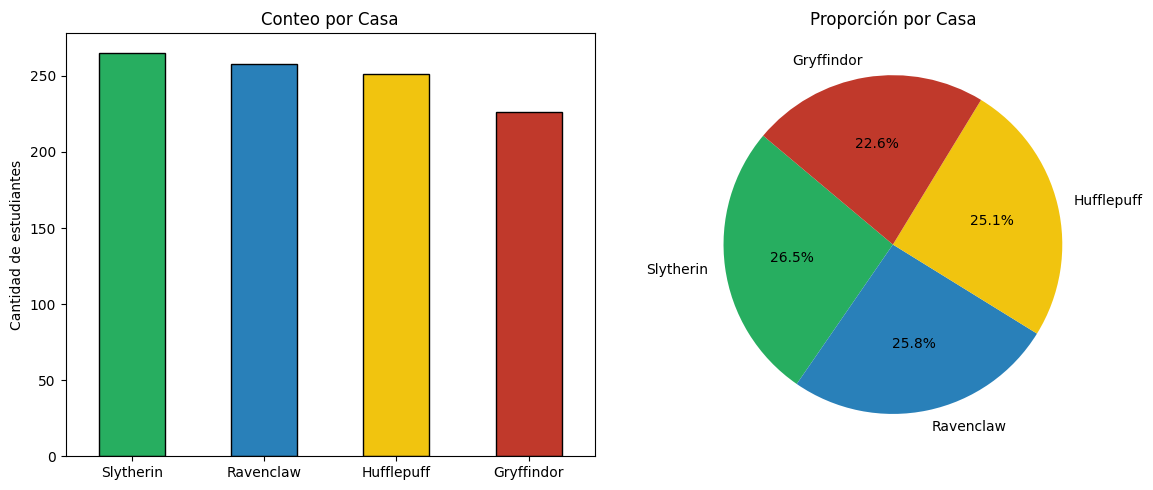

In [6]:
house_counts = df['House'].value_counts()
print('Distribución de casas:')
print(house_counts)
print(f'\nProporción mínima: {house_counts.min()/len(df):.1%} | Proporción máxima: {house_counts.max()/len(df):.1%}')

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

house_counts.plot(kind='bar', ax=axes[0], color=['#27ae60','#2980b9','#f1c40f','#c0392b'], edgecolor='black')
axes[0].set_title('Conteo por Casa')
axes[0].set_xlabel('')
axes[0].set_ylabel('Cantidad de estudiantes')
axes[0].tick_params(axis='x', rotation=0)

axes[1].pie(house_counts, labels=house_counts.index, autopct='%1.1f%%',
            colors=['#27ae60','#2980b9','#f1c40f','#c0392b'], startangle=140)
axes[1].set_title('Proporción por Casa')

plt.tight_layout()
plt.show()

Como podemos ver, tenemos una distribución bastante balanceada, lo que nos ayuda a decidir qué métrica utilizar al momento de evaluar el desempeño de cada modelo. En este caso, utilizaremos Accuracy, ya que no hay necesidad de priorizar una predicción sobre otra y contamos con clases objetivo balanceadas.

Ahora, visualizaremos la distribución de cada una de las variables numéricas.

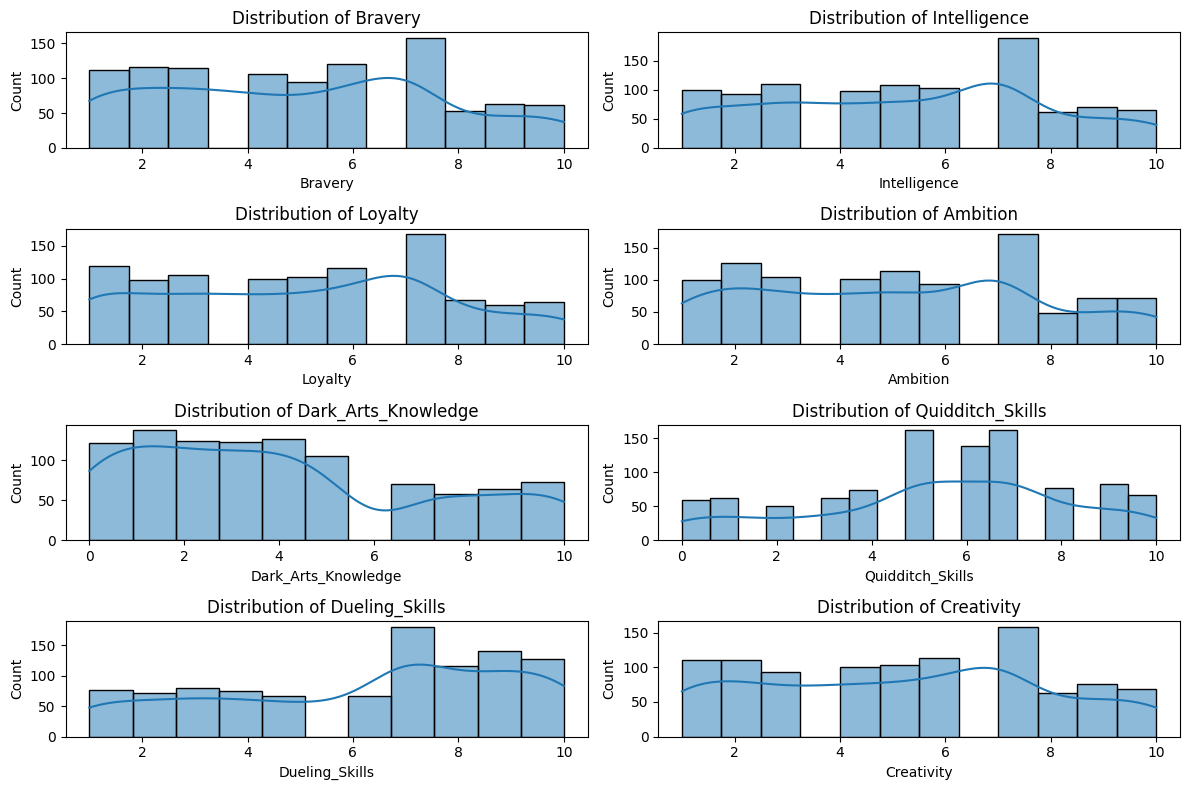

In [7]:
num_cols = ['Bravery','Intelligence','Loyalty','Ambition',
            'Dark_Arts_Knowledge','Quidditch_Skills','Dueling_Skills','Creativity']

fig, axs = plt.subplots(4, 2, figsize=(12, 8))

for ax, col in zip(axs.ravel(), num_cols):
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}')

fig.tight_layout()

Aquí se puede visualizar que no contamos con ninguna cola larga. Algunas variables complementarias, como Dark_Arts_Knowledge y Dueling_Skills, muestran una distribución espejeada. En general, todas parecen ser relativamente uniformes, con pequeños valles y, en algunos casos, distribuciones bimodales, como sería el caso de Ambition y Bravery.

Con estos datos, decidiremos utilizar únicamente un escalamiento estándar en el pipeline de preprocesamiento, ya que no observamos outliers extremos.

Ahora visualizaremos a mas detalle la relación entre estas variables numéricas, y la variable objetivo.

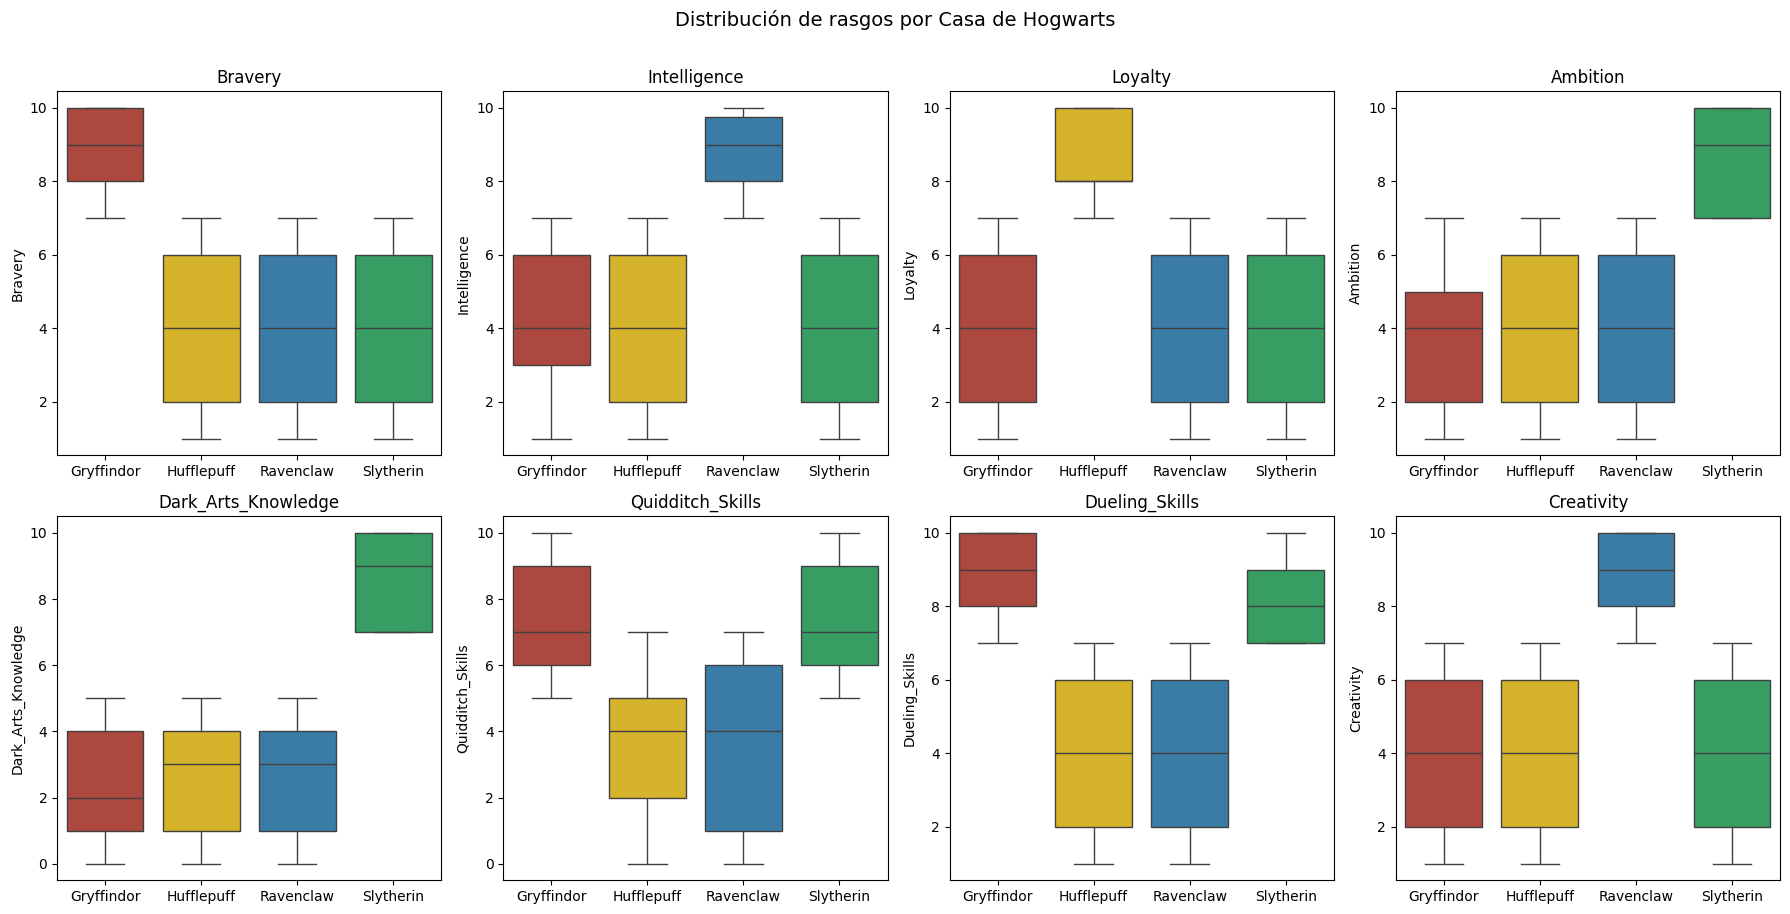

In [8]:
house_order = ['Gryffindor','Hufflepuff','Ravenclaw','Slytherin']
palette = {'Gryffindor':'#c0392b','Hufflepuff':'#f1c40f','Ravenclaw':'#2980b9','Slytherin':'#27ae60'}

fig, axes = plt.subplots(2, 4, figsize=(18, 9))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(
        data=df,
        x='House',
        y=col,
        hue='House',
        order=house_order,
        palette=palette,
        legend=False,
        ax=axes[i]
    )
    axes[i].set_title(col)
    axes[i].set_xlabel('')

plt.suptitle('Distribución de rasgos por Casa de Hogwarts', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

Aquí podemos ver que en todos los boxplots siempre hay una o dos casas marcadas, lo que nos indica que es probable que obtengamos valores de Accuracy altos, debido a que habrá atributos que tienen considerablemente más peso que otros y que, por sí solos, son capaces de predecir con bastante certeza un resultado.

Ahora visualizaremos la coorelación entre estas variables numéricas.

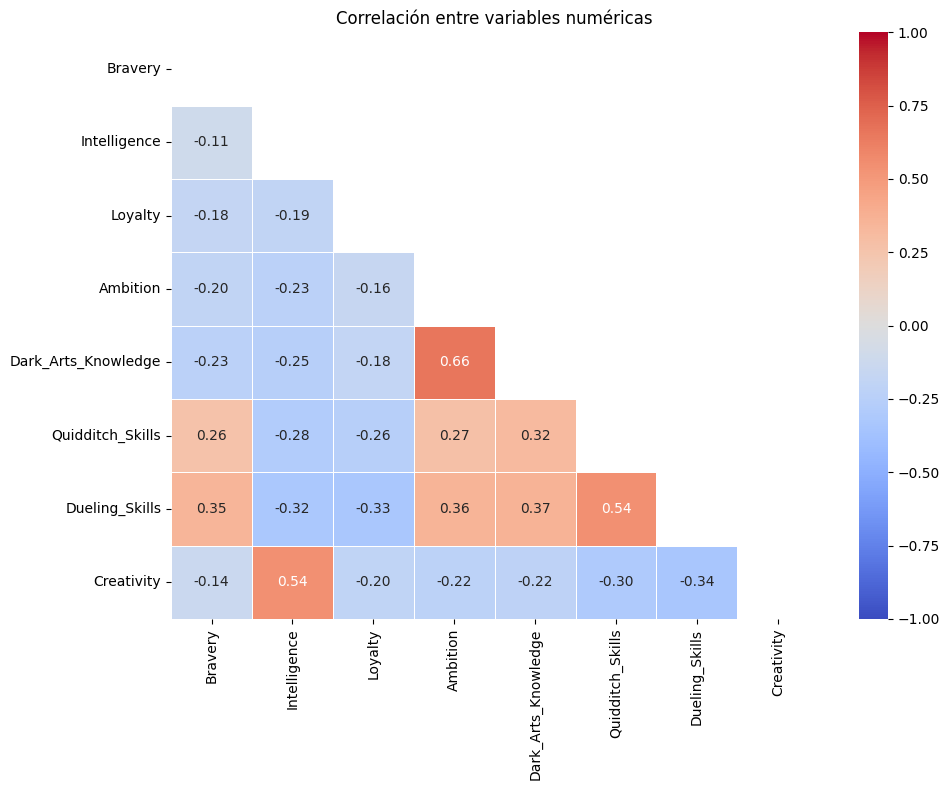

In [9]:
corr = df[num_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, vmin=-1, vmax=1, ax=ax, linewidths=0.5)
ax.set_title('Correlación entre variables numéricas')
plt.tight_layout()
plt.show()

Se pueden observar algunas relaciones, como Ambition con Dark_Arts_Knowledge, o Quidditch_Skills con Dueling_Skills. Esto nos indica que habrá variables que están bastante relacionadas y que, muy probablemente, por sí solas sean capaces de inferir la salida con bastante certeza. De igual manera, podemos observar el mismo comportamiento con Intelligence y Creativity.

Ahora, nos dirigiremos a la variable categórica, contando con Countplots la distribución de esta.

Distribución de Blood_Status:
Blood_Status
Half-blood     355
Pure-blood     332
Muggle-born    313
Name: count, dtype: int64


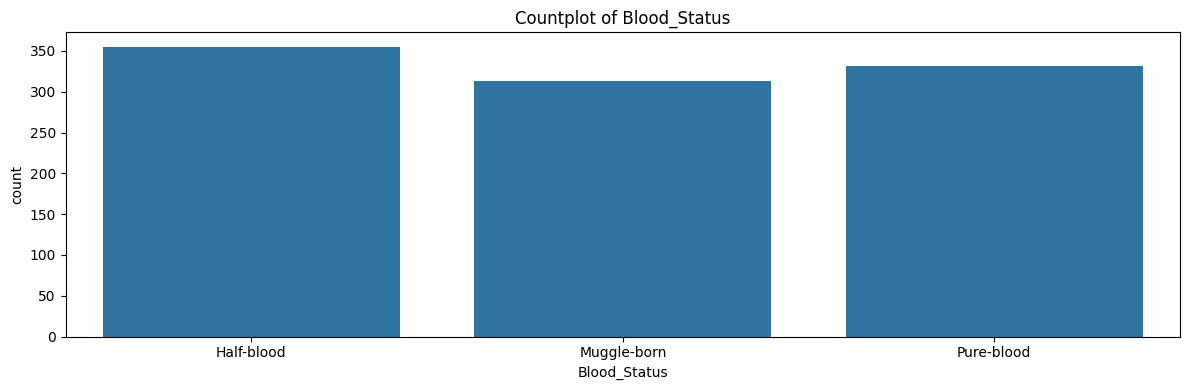

In [10]:
print('Distribución de Blood_Status:')
print(df['Blood_Status'].value_counts())

categorical_cols = ['Blood_Status']

fig, axs = plt.subplots(1, 1, figsize=(12, 4))

for col in categorical_cols:
    sns.countplot(data=df, x=col, ax=axs)
    axs.set_title(f'Countplot of {col}')

fig.tight_layout()

Al igual que la variable objetivo, esta se encuentra bastante balanceada. Debido a la naturaleza de este atributo, utilizaremos únicamente OneHotEncoder para eliminar cualquier orden cardinal implícito en la clase.

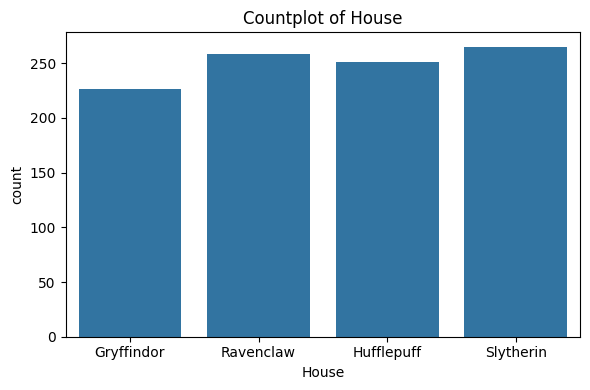

In [11]:
fig = plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='House')
plt.title('Countplot of House')
plt.tight_layout()

Por último, volvemos a mostrar el conteo de cada clase para reafirmar que utilizaremos Accuracy como métrica principal de evaluación. No obstante, también analizaremos Recall, Precision y F1-Score.

# **Pipeline de Preprocesamiento**

Ahora, crearemos el pipeline de preprocesamiento, aquellas modificaciones que haremos son las siguientes:
* Variables numéricas: StandardScaler.
* Variables categóricas: OneHotEncoder.

En este caso, no hubo necesidad de generar valores para datos nulos, ni la necesidad de realizar transformaciones adicionales.

In [12]:
num_features = ['Bravery','Intelligence','Loyalty','Ambition',
                'Dark_Arts_Knowledge','Quidditch_Skills','Dueling_Skills','Creativity']
cat_features = ['Blood_Status']

preprocessing = make_pipeline(
    ColumnTransformer(
        transformers=[
            ('cat', make_pipeline(OneHotEncoder(sparse_output=False)), cat_features),
            ('num', make_pipeline(StandardScaler()), num_features),
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    )
)

preprocessing

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['Blood_Status']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Bravery', 'Intelligence',
                                                   'Loyalty', 'Ambition',
                                                   'Dark_Arts_Knowledge',
                                                   'Quidditch_Skills',
                                                   'Dueling_Skills',
                                                   'Creativity'])],
                                   verbose_feature_names_out=False))])

Podemos ver como el pipeline se generó exitosamente.

# **Entrenamiento**

Ahora para el entrenamiento, dividiremos el conjunto de datos en dos subconjuntos, aquel de entrenamiento y el de prueba (80/20).

In [13]:
x = df.drop(columns=['House'])
y = df['House']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Consecuentemente, se aplica el preprocesamiento a X_train con fit_transform, luego se obtienen los nombres de las variables generadas por el ColumnTransformer, y finalmente se convierte el resultado en un DataFrame con esos nombres para poder visualizarlo correctamente.

In [14]:
X_train = preprocessing.fit_transform(X_train)
feature_names = preprocessing.named_steps['columntransformer'].get_feature_names_out()
X_train = pd.DataFrame(X_train, columns=feature_names)
X_train.head()

,Blood_Status_Half-blood,Blood_Status_Muggle-born,Blood_Status_Pure-blood,Bravery,Intelligence,Loyalty,Ambition,Dark_Arts_Knowledge,Quidditch_Skills,Dueling_Skills,Creativity
0,1.0,0.0,0.0,-1.494501,-0.835413,1.441284,-1.498754,-1.300088,-0.535583,-1.499050,-0.447028
1,0.0,1.0,0.0,1.094180,-1.588038,0.691104,0.690540,-0.027441,1.324079,0.973610,-0.079859
2,0.0,1.0,0.0,-1.494501,1.046148,-1.559437,-1.133872,0.290720,-0.907515,-0.439339,1.755984
3,0.0,1.0,0.0,1.833803,-0.459101,0.691104,0.690540,-0.345603,0.580214,0.973610,0.654478
4,0.0,0.0,1.0,-1.124689,1.798773,-1.559437,-1.498754,-0.981926,-0.535583,-0.086102,1.021647


Por último en esta sección, se aplica el preprocesamiento a X_test utilizando transform (sin volver a ajustar el pipeline), y posteriormente se convierte el resultado en un DataFrame usando los mismos nombres de columnas para mantener la consistencia con el conjunto de entrenamiento.

In [15]:
X_test = preprocessing.transform(X_test)
X_test = pd.DataFrame(X_test, columns=feature_names)
X_test.head()

,Blood_Status_Half-blood,Blood_Status_Muggle-born,Blood_Status_Pure-blood,Bravery,Intelligence,Loyalty,Ambition,Dark_Arts_Knowledge,Quidditch_Skills,Dueling_Skills,Creativity
0,0.0,1.0,0.0,-1.494501,1.046148,-0.809257,0.690540,-0.663764,-1.651379,-1.145813,1.021647
1,1.0,0.0,0.0,1.833803,0.293524,-0.059077,-1.133872,-0.345603,1.324079,0.973610,-0.814196
2,1.0,0.0,0.0,0.724368,-0.459101,-0.434167,0.690540,1.881528,0.208282,0.267136,-1.181365
3,1.0,0.0,0.0,-0.015255,0.293524,1.816374,-0.404107,0.290720,0.580214,-0.792576,0.654478
4,1.0,0.0,0.0,-0.754878,-0.459101,-1.184347,0.690540,1.563366,1.324079,0.620373,-1.548534


## Entrenamiento de modelos y evaluacion

Ahora, para empezar con el entrenamiento de los 3 modelos de clasificación, comenzaremos por definir una función que nos servirá para evaluar cada uno en base a las métricas anteriormente señaladas: Accuracy, Precision, Recall y F1 Score.

In [16]:
def evaluate_model(model, X, y):

    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }

Los modelos a utilizar son los siguientes:
* Regresión Logística
* SVC
* Bosque Aleatorio

#### Modelo 1 - [Regresión Logística]

Para este, definimos los hiperparámetros a probar con GridSearchCV, dividio en 5 particiones, y evaluados con Accuracy.

In [17]:
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=5000),
    param_grid_lr,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

Hacemos fit al modelo.

In [18]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=5000, random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'class_weight': [None, 'balanced'],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy', verbose=1)

Y una vez terminado este proceso, visualizamos la mejor combinación de hiperparámetros encontrada.

In [19]:
grid_search.best_params_

{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}

Ahora, evaluamos el desempeño del modelo con ambos conjuntos y visualizamos los resultados obtenidos.

In [20]:
model_LR = grid_search.best_estimator_

train_metrics = evaluate_model(model_LR, X_train, y_train)
test_metrics = evaluate_model(model_LR, X_test, y_test)

metrics_df = pd.DataFrame({
    "Train": train_metrics,
    "Test": test_metrics})
metrics_df.T

,Accuracy,Precision,Recall,F1-Score
Train,1.000,1.000000,1.000,1.000000
Test,0.995,0.995081,0.995,0.994993


Aquí podemos observar que obtuvimos un 1.0 en los datos de entrenamiento y un 0.995 en los de prueba, lo que podría indicar un ligero sobreajuste. Sin embargo, este resultado puede considerarse justificable debido a las variables predominantes identificadas durante el EDA.

#### Modelo 2 - [SVC]

Realizamos el mismo proceso para el modelo utilizando SVC.

In [21]:
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
}

grid_svm = GridSearchCV(
    SVC(random_state=42),
    param_grid_svm,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

In [22]:
grid_svm.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
             scoring='accuracy', verbose=1)

In [23]:
grid_svm.best_params_

{'C': 0.1, 'kernel': 'rbf'}

In [24]:
model_SVM = grid_svm.best_estimator_

train_metrics = evaluate_model(model_SVM, X_train, y_train)
test_metrics = evaluate_model(model_SVM, X_test, y_test)

metrics_df = pd.DataFrame({
    "Train": train_metrics,
    "Test": test_metrics})
metrics_df.T

,Accuracy,Precision,Recall,F1-Score
Train,0.99875,0.998756,0.99875,0.998750
Test,0.99500,0.995081,0.99500,0.994993


En este caso, en términos de Accuracy, obtuvimos un desempeño igual al de la Regresión Logística en el subconjunto de prueba, con 0.995. Sin embargo, el desempeño fue ligeramente menor por centésimas en el conjunto de entrenamiento.

#### Modelo 3 - [Clasificador de Bosque Aleatorio]

Por último, probamos con el clasificador de bosque aleatorio.

In [25]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced'],
    'max_features': ['sqrt', 'log2']
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

In [26]:
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [10, 15, 20, None],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

In [27]:
grid_rf.best_params_

{'class_weight': 'balanced',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [28]:
model_RF = grid_rf.best_estimator_

train_metrics = evaluate_model(model_RF, X_train, y_train)
test_metrics = evaluate_model(model_RF, X_test, y_test)

metrics_df = pd.DataFrame({
    "Train": train_metrics,
    "Test": test_metrics})
metrics_df.T

,Accuracy,Precision,Recall,F1-Score
Train,1.00,1.00,1.00,1.00
Test,0.99,0.99,0.99,0.99


En este caso, terminamos con un puntaje de 1.0 en el subconjunto de entrenamiento, igual al de la Regresión Logística, pero con un desempeño ligeramente inferior en el subconjunto de prueba, con 0.99.

## Evaluacion final

Para comparar cada modelo implementando la mejor combinación de los hiperparámetros, visualizaremos nuevamente cada puntaje obtenido.

In [29]:
results = []

metrics_lr = evaluate_model(model_LR, X_test, y_test)
results.append({'Model': 'Logistic Regression', **metrics_lr})
print(f"\nLogistic Regression:")
print(f"  Accuracy:  {metrics_lr['Accuracy']:.4f}")
print(f"  Precision: {metrics_lr['Precision']:.4f}")
print(f"  Recall:    {metrics_lr['Recall']:.4f}")
print(f"  F1-Score:  {metrics_lr['F1-Score']:.4f}")

metrics_svm = evaluate_model(model_SVM, X_test, y_test)
results.append({'Model': 'SVM', **metrics_svm})
print(f"\nSVM:")
print(f"  Accuracy:  {metrics_svm['Accuracy']:.4f}")
print(f"  Precision: {metrics_svm['Precision']:.4f}")
print(f"  Recall:    {metrics_svm['Recall']:.4f}")
print(f"  F1-Score:  {metrics_svm['F1-Score']:.4f}")

metrics_rf = evaluate_model(model_RF, X_test, y_test)
results.append({'Model': 'Random Forest', **metrics_rf})
print(f"\nRandom Forest:")
print(f"  Accuracy:  {metrics_rf['Accuracy']:.4f}")
print(f"  Precision: {metrics_rf['Precision']:.4f}")
print(f"  Recall:    {metrics_rf['Recall']:.4f}")
print(f"  F1-Score:  {metrics_rf['F1-Score']:.4f}")

comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.set_index('Model')
print(comparison_df)


Logistic Regression:
  Accuracy:  0.9950
  Precision: 0.9951
  Recall:    0.9950
  F1-Score:  0.9950

SVM:
  Accuracy:  0.9950
  Precision: 0.9951
  Recall:    0.9950
  F1-Score:  0.9950

Random Forest:
  Accuracy:  0.9900
  Precision: 0.9900
  Recall:    0.9900
  F1-Score:  0.9900
                     Accuracy  Precision  Recall  F1-Score
Model                                                     
Logistic Regression     0.995   0.995081   0.995  0.994993
SVM                     0.995   0.995081   0.995  0.994993
Random Forest           0.990   0.990000   0.990  0.990000


Aquí podemos llegar a la conclusión de que el mejor modelo fue la Regresión Logística, debido a su simplicidad y a su mejor rendimiento frente a los otros modelos, aunque la diferencia haya sido solo por centésimas.

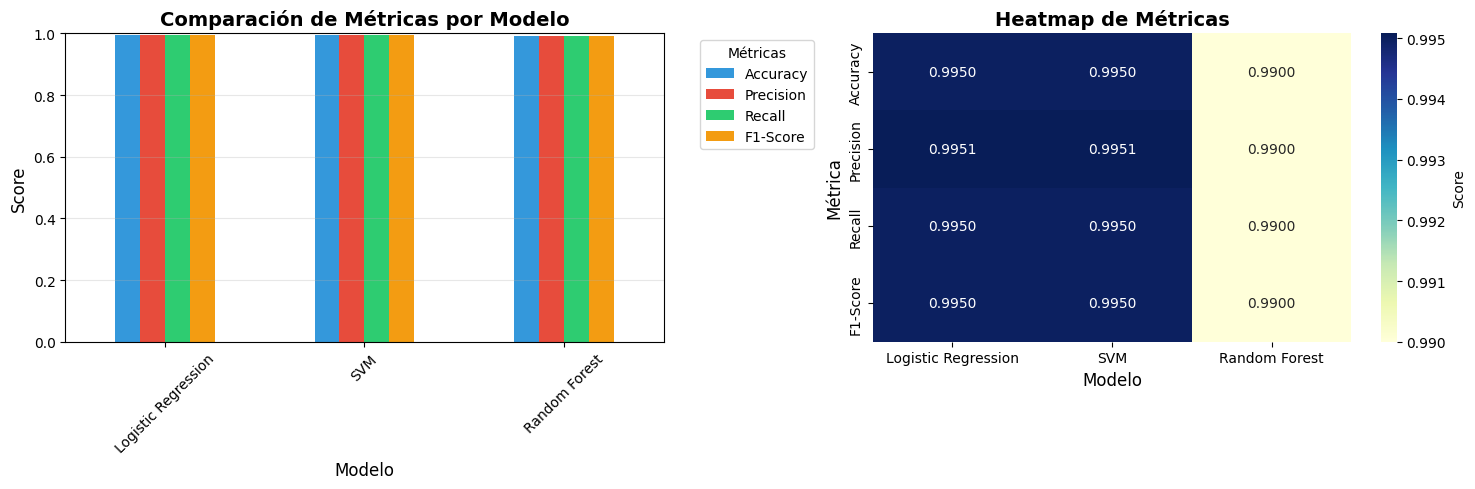

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

comparison_df.plot(kind='bar', ax=axes[0], rot=45, color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
axes[0].set_title('Comparación de Métricas por Modelo', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_xlabel('Modelo', fontsize=12)
axes[0].legend(title='Métricas', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim(0, 1)

sns.heatmap(comparison_df.T, annot=True, fmt='.4f', cmap='YlGnBu',
            ax=axes[1], cbar_kws={'label': 'Score'})
axes[1].set_title('Heatmap de Métricas', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Modelo', fontsize=12)
axes[1].set_ylabel('Métrica', fontsize=12)

plt.tight_layout()
plt.show()

De igual manera, podemos visualizar mejor sus rendimientos con una gráfica de barras y un heatmap.

## Analisis del mejor modelo

Ahora que tenemos el mejor modelo, podemos visualizar su desempeño aislado de los demás.

In [31]:
best_model_name = comparison_df['Accuracy'].idxmax()
best_accuracy = comparison_df['Accuracy'].max()

print(f"\nMejor modelo: {best_model_name}")
print(f"Accuracy: {best_accuracy:.4f}")

if best_model_name == 'Logistic Regression':
    best_model = model_LR
elif best_model_name == 'Random Forest':
    best_model = model_RF
else:
    best_model = model_SVM

print(f"\nMétricas:")
print(f"  Accuracy:  {comparison_df.loc[best_model_name, 'Accuracy']:.4f}")
print(f"  Precision: {comparison_df.loc[best_model_name, 'Precision']:.4f}")
print(f"  Recall:    {comparison_df.loc[best_model_name, 'Recall']:.4f}")
print(f"  F1-Score:  {comparison_df.loc[best_model_name, 'F1-Score']:.4f}")


Mejor modelo: Logistic Regression
Accuracy: 0.9950

Métricas:
  Accuracy:  0.9950
  Precision: 0.9951
  Recall:    0.9950
  F1-Score:  0.9950


Dado que nuestra métrica principal fue Accuracy, es esta la que señalamos en la parte superior, con un puntaje de 0.995.

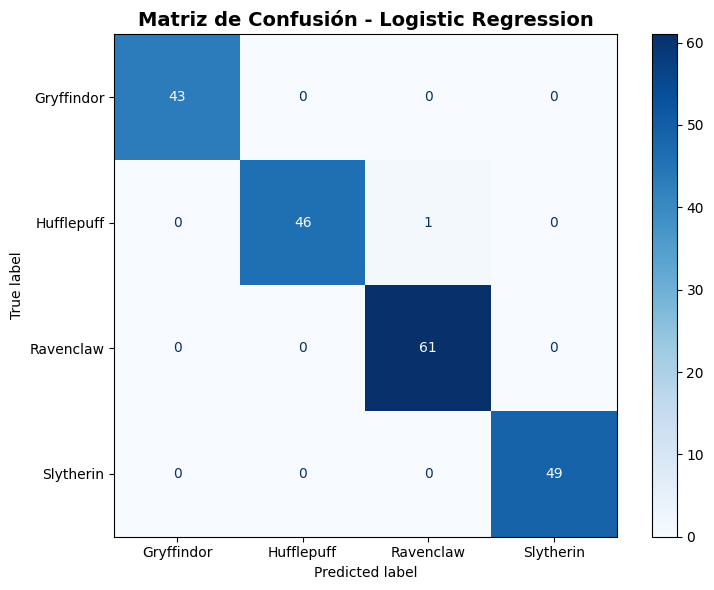

In [32]:
y_pred_best = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best)

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Gryffindor', 'Hufflepuff', 'Ravenclaw', 'Slytherin'])
disp.plot(cmap='Blues', ax=ax, values_format='d')
ax.set_title(f'Matriz de Confusión - {best_model_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Podemos visualizar adicionalmente su desempeño con esta matriz de confusión, mostrando solamente un valor equivocado.

In [33]:
report = classification_report(y_test, y_pred_best)
print(report)

              precision    recall  f1-score   support

  Gryffindor       1.00      1.00      1.00        43
  Hufflepuff       1.00      0.98      0.99        47
   Ravenclaw       0.98      1.00      0.99        61
   Slytherin       1.00      1.00      1.00        49

    accuracy                           0.99       200
   macro avg       1.00      0.99      1.00       200
weighted avg       1.00      0.99      0.99       200



Finalmente en el entrenamiento, obtenemos el reporte de clasificación.

## Serialización con JobLib

Para el último paso en este colab, procedemos a serializar el modelo utilizando la librería JobLib, y lo exportamos para ser utilizado en otro entorno.

In [34]:
best_model = model_LR
final_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("model", best_model)
])

final_pipeline.fit(x, y)

joblib.dump(final_pipeline, "modelo_harrypotter.joblib")
files.download("modelo_harrypotter.joblib")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>